In [4]:
%load_ext autoreload
%autoreload 2

import os
import sys

module_path = os.path.abspath(os.path.join('..'))
sys.path.insert(0, module_path)

from src import Interception2D
from src.scenarios import make_escape_scenarios, plot_scenarios
from src.common import n_degree_curve
from pathlib import Path
import numpy as np
import pandas as pd
from joblib import Parallel, delayed, dump, load
import matplotlib.pyplot as plt
from scipy import interpolate
from matplotlib import cm
import matplotlib
from typing import Union
from stable_baselines3 import SAC
import plotly.graph_objects as go

BASE_PATH = Path(os.getcwd())
for _ in range(len(BASE_PATH.parents) + 1):
    if os.path.basename(BASE_PATH) == 'SmartInterception':
        break
    BASE_PATH = BASE_PATH.parents[0]
    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def single_simulation(
    d: float, 
    q: float, 
    eps: float,
    target_action: Union[str, float] = None,
    missile_action: Union[str, float] = 'model'
):
    
    scenarios, _ = make_escape_scenarios(
        n=1, 
        seed=1, 
        target_centered=True,
        d_min=d,
        d_max=d,
        q_min=q,
        q_max=q,
        eps_min=eps,
        eps_max=eps
    )
    
    env = Interception2D(agent='target', bounds='bounds.yaml', scenarios=scenarios)
    
    if missile_action == 'model':

        target_model = SAC.load(os.path.join(BASE_PATH, 'models', 'SAC-T_1'), env=env)
        env_ = Interception2D(
            agent='both',
            bounds='bounds.yaml',
            scenarios=[],
            model=target_model
        )
        model = SAC.load(os.path.join(BASE_PATH, 'models', 'SAC-M_2'), env=env_)
        
        prop = 0
        n_hits = 0
        
        for i in range(20):
            obs = env.reset()
            done = False
            while not done:
                action, _states = model.predict(obs)
                obs, rewards, done, _ = env.step(action)
            if 'hit' in env.status.lower():
                n_hits += 1
            prop = n_hits / (i + 1)
        
        return np.array(
            [d, q, prop], 
            dtype=np.float32
        )
    
    if target_action == 'model':
        model = SAC.load(os.path.join(BASE_PATH, 'models', 'SAC-T'), env=env, device='cpu')
        
        prop = 0
        n_hits = 0
        
        for i in range(20):
            obs = env.reset()
            done = False
            while not done:
                action, _states = model.predict(obs)
                obs, rewards, done, _ = env.step(action)
            if 'hit' in env.status.lower():
                n_hits += 1
            prop = n_hits / (i + 1)
        
        return np.array(
            [d, q, prop], 
            dtype=np.float32
        )
            
    else:
        obs = env.reset()
        done = False
        while not done:
            action = target_action
            obs, rewards, done, _ = env.step(action)

        hit = True if 'hit' in env.status.lower() else False

        eps_term = np.rad2deg(env._obs[7])
        eps_term = eps_term if abs(eps_term) < 90 else eps_term - np.copysign(180, eps_term)

        return np.array(
            [d, q, env.t, env._obs[5] * env.missile.speed_of_sound, eps_term, hit], 
            dtype=np.float32
        )

***Общие объекты***

In [8]:
PATH_TO_SAVE = os.path.join(BASE_PATH, 'files')

### 1. Цель бездействует

In [18]:
distances = np.linspace(5000, 80000, 51)
view_angles = np.linspace(0, 180, 19)
errors = np.linspace(-40, 40, 5)
combinations = []
data = {}

for d in distances:
    for q in view_angles:
        combinations.append((d, q))

In [64]:
FULL_PATH = os.path.join(PATH_TO_SAVE, 'attack_zone_default.pkl')
if os.path.exists(FULL_PATH):
    data = load(FULL_PATH)
else:
    for eps in errors:
        res = Parallel(n_jobs=-2, verbose=1)(delayed(single_simulation)(combination[0], combination[1], eps, target_action=0) for combination in combinations)
        res = np.array(res)
        data[eps] = pd.DataFrame(
            {
                'd': res[:, 0], 
                'q': res[:, 1],
                't': res[:, 2], 
                'vel_term': res[:, 3],
                'eps_term': res[:, 4],
                'hit': res[:, 5]
            }
        )
    dump(data, FULL_PATH)
    del data

In [19]:
FULL_PATH = os.path.join(PATH_TO_SAVE, 'attack_zone_default.pkl')
data = load(FULL_PATH)

edges = {}
for eps in errors:
    hit_only = data[eps][data[eps].hit == 1.]
    edges[eps] = pd.DataFrame(columns=['theta', 'r'])
    for i, q in enumerate(view_angles):
        edges[eps].loc[i] = [q, hit_only[hit_only.q == q].d.max()]
    for j, q in enumerate(view_angles[1:] + 180.):
        edges[eps].loc[i + j + 1] = [q, hit_only[hit_only.q == 360. - q].d.max()]

In [20]:
plot_data = [
    go.Scatterpolar(
        name=f'eps = {eps} [grad]',
        r = edge.r,
        theta =  edge.theta,
#         fill='toself',
        mode='lines',
        line=dict(width=3)
    ) for eps, edge in edges.items()
]

plot_data.extend(
    [
        go.Scatterpolar(
            name=f'target',
            r = [0, 15e3],
            theta =  [180, 180],
            mode='lines',
            showlegend=False,
            line=dict(width=5, color='rgb(0, 100, 250)')
        ),
        go.Scatterpolar(
            name=f'target',
            r = [15e3, 7e3],
            theta =  [180, 180 + 10],
            mode='lines',
            showlegend=False,
            line=dict(width=5, color='rgb(0, 100, 250)')
        ),
        go.Scatterpolar(
            name=f'target',
            r = [15e3, 7e3],
            theta =  [180, 180 - 10],
            mode='lines',
            showlegend=False,
            line=dict(width=5, color='rgb(0, 100, 250)')
        )
    ]
)


layout = go.Layout(
    title=dict(
        text='Цель бездействует', 
        x=0.42,
        font=dict(size=25)
    ),
    font=dict(
        size=15,
        family='Courier New',
        color='rgb(0, 0, 0)'
    ),
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 90e3],
            angle=0
        ),
#         sector = [0, 180],
        angularaxis=dict(
        )
    ),
    paper_bgcolor='rgb(255, 255, 255)',
#     polar_bgcolor='rgb(0, 0, 0)',
    showlegend=True
)


fig = go.Figure(
    data = plot_data,
    layout=layout
)

fig.show()

### 2. Цель уходит с постоянной перегрузкой

In [5]:
distances = np.linspace(5000, 80000, 51)
view_angles = np.linspace(0, 350, 36)
errors = np.linspace(-40, 40, 5)
combinations = []
data = {}

for d in distances:
    for q in view_angles:
        combinations.append((d, q))

In [171]:
FULL_PATH = os.path.join(PATH_TO_SAVE, 'attack_zone_max_overload.pkl')
if os.path.exists(FULL_PATH):
    data = load(FULL_PATH)
else:
    for eps in errors:
        res = Parallel(n_jobs=-2, verbose=1)(delayed(single_simulation)(combination[0], combination[1], eps, target_action=0.4) for combination in combinations)
        res = np.array(res)
        data[eps] = pd.DataFrame(
            {
                'd': res[:, 0], 
                'q': res[:, 1],
                't': res[:, 2], 
                'vel_term': res[:, 3],
                'eps_term': res[:, 4],
                'hit': res[:, 5]
            }
        )
    dump(data, FULL_PATH)
    del data

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-2)]: Done 436 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-2)]: Done 786 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-2)]: Done 1236 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-2)]: Done 1786 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-2)]: Done 1836 out of 1836 | elapsed: 10.3min finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-2)]: Done 436 tasks      | elapsed:   38.2s
[Parallel(n_jobs=-2)]: Done 786 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-2)]: Done 1236 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-2)]: Done 1786 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-2)]: Done

In [6]:
FULL_PATH = os.path.join(PATH_TO_SAVE, 'attack_zone_const_overload_5.pkl')
data = load(FULL_PATH)

edges = {}
for eps in errors:
    hit_only = data[eps][data[eps].hit == 1.]
    edges[eps] = pd.DataFrame(columns=['theta', 'r'])
    for i, q in enumerate(view_angles):
        edges[eps].loc[i] = [q, hit_only[hit_only.q == q].d.max()]
    edges[eps].loc[i + 1] = edges[eps].iloc[0]

In [17]:
plot_data = [
    go.Scatterpolar(
        name=f'eps = {eps} [grad]',
        r = edge.r,
        theta =  edge.theta,
#         fill='toself',
        mode='lines',
        line=dict(width=3)
    ) for eps, edge in edges.items()
]

theta = np.linspace(180, 270, 10)
r = abs(np.sin(np.radians(theta))) * 15e3

plot_data.extend(
    [
        go.Scatterpolar(
            name=f'target',
            r=r,
            theta=theta,
            mode='lines',
            showlegend=False,
            line=dict(width=4, color='rgb(0, 100, 250)')
        ),
        go.Scatterpolar(
            name=f'target',
            r = [r[-1], r[-1] / np.cos(np.radians(28))],
            theta =  [theta[-1], theta[-1] + 28],
            mode='lines',
            showlegend=False,
            line=dict(width=4, color='rgb(0, 100, 250)')
        ),
        go.Scatterpolar(
            name=f'target',
            r = [r[-1] / np.cos(np.radians(28)), r[-1] * 1.1],
            theta =  [theta[-1] + 28, theta[-1]],
            mode='lines',
            showlegend=False,
            line=dict(width=4, color='rgb(0, 100, 250)')
        ),
        go.Scatterpolar(
            name=f'target',
            r = [r[-1] / np.cos(np.radians(28)), r[-1] * 0.9],
            theta =  [theta[-1] + 28, theta[-1]],
            mode='lines',
            showlegend=False,
            line=dict(width=4, color='rgb(0, 100, 250)')
        )
    ]
)


layout = go.Layout(
    title=dict(
        text='Цель совершает маневр с постоянной перегрузкой 5g', 
        x=0.43,
        font=dict(size=25)
    ),
    font=dict(
        size=15,
        family='Courier New',
        color='rgb(0, 0, 0)'
    ),
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 90e3],
            angle=0
        ),
        sector = [0, 360],
        angularaxis=dict(
        )
    ),
    paper_bgcolor='rgb(255, 255, 255)',
#     polar_bgcolor='rgb(250, 250, 250)',
    showlegend=True
)


fig = go.Figure(
    data = plot_data,
    layout=layout
)

fig.show()

### 3. Цель управляется SAC моделью

In [18]:
29 * 19  * 4 * 20

44080

In [2]:
distances = np.linspace(10e3, 80e3, 29)
view_angles = np.linspace(0, 180, 19)
errors = np.linspace(-40, 40, 5)
combinations = []
data = {}

for d in distances:
    for q in view_angles:
        combinations.append((d, q))

In [26]:
FULL_PATH = os.path.join(PATH_TO_SAVE, 'attack_zone_sac_t.pkl')
if os.path.exists(FULL_PATH):
    data = load(FULL_PATH)
else:
    for eps in errors:
        res = Parallel(n_jobs=-3, verbose=1)(delayed(single_simulation)(combination[0], combination[1], eps, target_action='model') for combination in combinations)
        res = np.array(res)
        data[eps] = pd.DataFrame(
            {
                'd': res[:, 0], 
                'q': res[:, 1],
                'prop': res[:, 2]
            }
        )
    dump(data, FULL_PATH)
    del data

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-3)]: Done  38 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-3)]: Done 188 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-3)]: Done 438 tasks      | elapsed: 50.6min
[Parallel(n_jobs=-3)]: Done 551 out of 551 | elapsed: 71.3min finished
[Parallel(n_jobs=-3)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-3)]: Done  38 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-3)]: Done 188 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-3)]: Done 438 tasks      | elapsed: 48.3min
[Parallel(n_jobs=-3)]: Done 551 out of 551 | elapsed: 69.3min finished
[Parallel(n_jobs=-3)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-3)]: Done  38 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-3)]: Done 188 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-3)]: Done 438 tasks      | elapsed: 48.5min
[Parallel(n_jobs=-3)]: Done 551 out of 551 | elapsed: 69.4min finished
[

In [9]:
FULL_PATH = os.path.join(PATH_TO_SAVE, 'attack_zone_sac_t.pkl')
data = load(FULL_PATH)

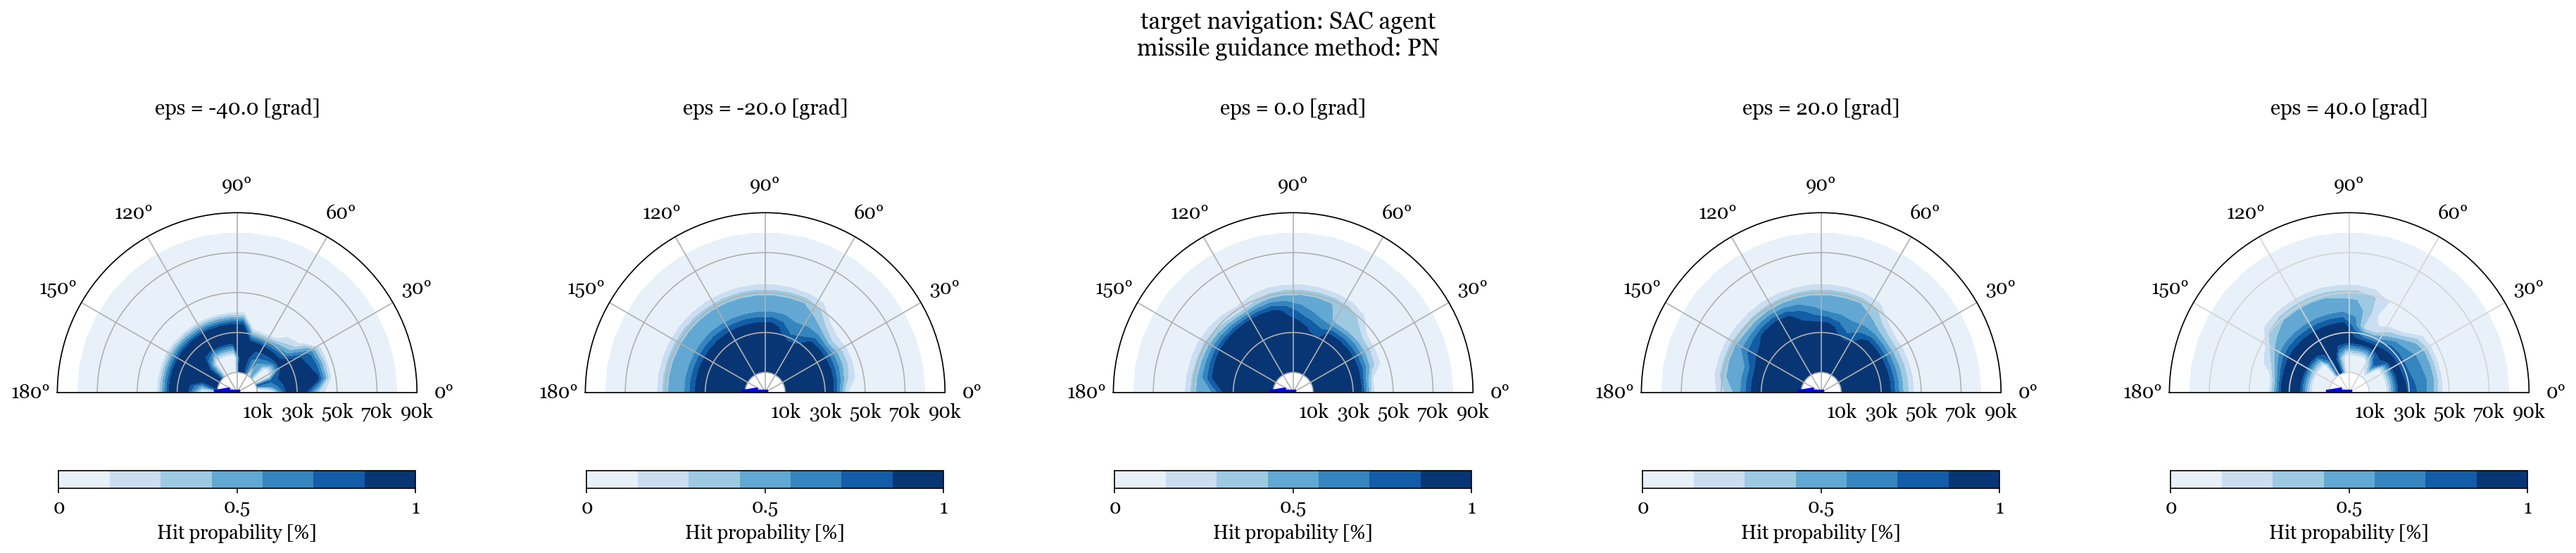

In [11]:
rc = {"font.family": "serif",
      "mathtext.fontset": "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Georgia"] + plt.rcParams["font.serif"]
matplotlib.rcParams.update({'font.size': 13})

azimuths = np.linspace(0, 180, 20)
zeniths = np.linspace(10e3, 80e3, 10)

r, theta = np.meshgrid(zeniths, np.radians(azimuths))

errors = np.linspace(-40, 40, 5)

fig, ax = plt.subplots(figsize=(25, 5), dpi=150, nrows=1, ncols=5, subplot_kw=dict(projection='polar'))
plt.tight_layout(w_pad=0, h_pad=0, pad=0)
fig.suptitle('target navigation: SAC agent\nmissile guidance method: PN', y=1.2, fontsize=16)

for i, eps in enumerate(errors):
    
    if eps != -40:
        distances = np.linspace(10e3, 80e3, 29)
        view_angles = np.linspace(0, 180, 19)
    else:
        distances = np.linspace(10e3, 80e3, 51)
        view_angles = np.linspace(0, 180, 37)
    
    prop = interpolate.interp2d(
        view_angles,
        distances,
        np.reshape(data[eps].prop.to_numpy(), (len(distances), len(view_angles))), 
        kind='linear'
    )
    
    values = prop(azimuths, zeniths).T

    cf = ax[i].contourf(theta, r, values, cmap=cm.Blues, vmax=1.)
    cb = plt.colorbar(
        cf, 
        shrink=0.78, 
        aspect=20, 
        orientation='horizontal', 
        anchor=(0.5, 2.5), 
        ticks=[0, 0.525, 1.05], 
        label='Hit propability [%]', 
        ax=ax[i]
    )
    cb.ax.set_xticklabels(['0', '0.5', '1']) 

    ax[i].plot([np.pi, np.pi], [0, 10e3], color='blue', lw=4)
    ax[i].plot([np.pi, np.pi - np.radians(10)], [10e3, 5e3], color='blue', lw=4)

    ax[i].set_thetamin(0)
    ax[i].set_thetamax(180)
    ax[i].tick_params(axis='x', pad=8)

    ax[i].set_rmin(0)
    ax[i].set_rmax(90e3)

    ax[i].set_rticks([10e3, 30e3, 50e3, 70e3, 90e3])
    ax[i].set_yticklabels(['10k', '30k', '50k', '70k', '90k'])

    ax[i].set_title(f'eps = {eps} [grad]', fontsize=14)

plt.grid(c='lightgray')
plt.show()
fig.savefig(os.path.join(BASE_PATH, 'files', 'plots', 'attack_zones', 'sac_pn.png'), dpi=200, bbox_inches='tight')

### 4. Полноценная дуэль SAC моделей

In [12]:
distances = np.linspace(10e3, 80e3, 29)
view_angles = np.linspace(0, 180, 19)
errors = np.linspace(-40, 40, 5)
combinations = []
data = {}

for d in distances:
    for q in view_angles:
        combinations.append((d, q))

In [13]:
FULL_PATH = os.path.join(PATH_TO_SAVE, 'attack_zone_sac_t_sac_m.pkl')
if os.path.exists(FULL_PATH):
    data = load(FULL_PATH)
else:
    for eps in errors:
        res = Parallel(n_jobs=-3, verbose=1)(delayed(single_simulation)(combination[0], combination[1], eps, target_action='model') for combination in combinations)
        res = np.array(res)
        data[eps] = pd.DataFrame(
            {
                'd': res[:, 0], 
                'q': res[:, 1],
                'prop': res[:, 2]
            }
        )
    dump(data, FULL_PATH)
    del data

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-3)]: Done  38 tasks      | elapsed:   49.0s
[Parallel(n_jobs=-3)]: Done 188 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-3)]: Done 438 tasks      | elapsed: 69.5min
[Parallel(n_jobs=-3)]: Done 551 out of 551 | elapsed: 107.8min finished


In [13]:
FULL_PATH = os.path.join(PATH_TO_SAVE, 'attack_zone_sac_t_sac_m.pkl')
data = load(FULL_PATH)

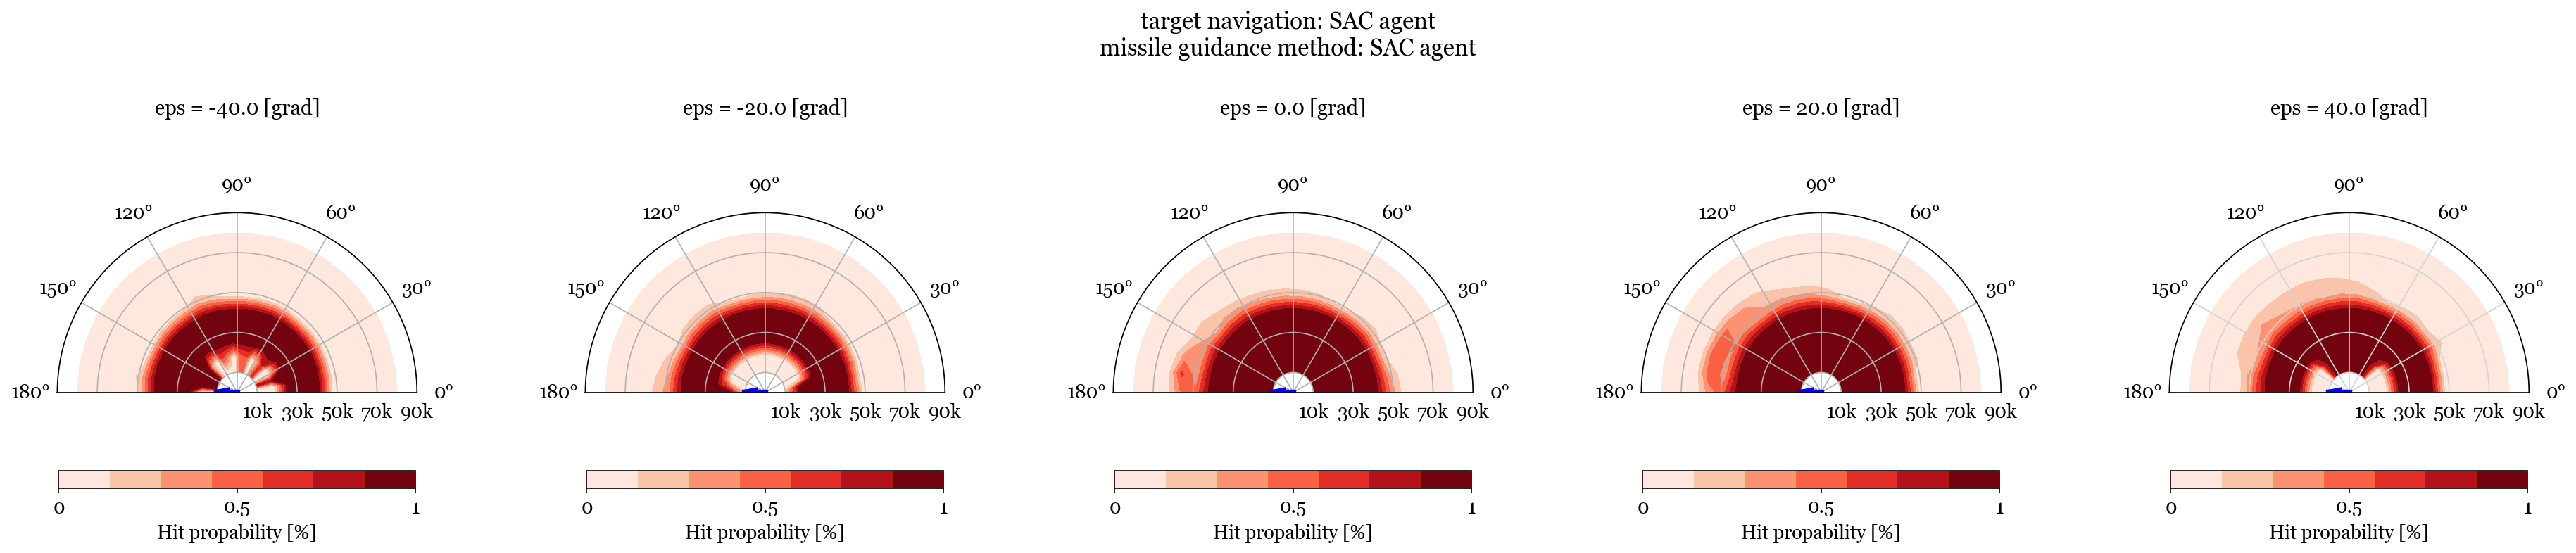

In [14]:
rc = {"font.family": "serif",
      "mathtext.fontset": "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Georgia"] + plt.rcParams["font.serif"]
matplotlib.rcParams.update({'font.size': 13})

azimuths = np.linspace(0, 180, 20)
zeniths = np.linspace(10e3, 80e3, 10)

r, theta = np.meshgrid(zeniths, np.radians(azimuths))

distances = np.linspace(10e3, 80e3, 29)
view_angles = np.linspace(0, 180, 19)
errors = np.linspace(-40, 40, 5)

fig, ax = plt.subplots(
    figsize=(25, 5), 
    dpi=150, 
    nrows=1, 
    ncols=5, 
    subplot_kw=dict(projection='polar')
)
plt.tight_layout(w_pad=0, h_pad=0, pad=0)
fig.suptitle('target navigation: SAC agent\nmissile guidance method: SAC agent', y=1.2, fontsize=16)

for i, eps in enumerate(errors):
    
    prop = interpolate.interp2d(
        view_angles,
        distances,
        np.reshape(data[eps].prop.to_numpy(), (len(distances), len(view_angles))), 
        kind='linear'
    )
    
    values = prop(azimuths, zeniths).T

    cf = ax[i].contourf(theta, r, values, cmap=cm.Reds, vmax=1.)
    cb = plt.colorbar(
        cf, 
        shrink=0.78, 
        aspect=20, 
        orientation='horizontal', 
        anchor=(0.5, 2.5), 
        ticks=[0, 0.525, 1.05], 
        label='Hit propability [%]', 
        ax=ax[i]
    )
    cb.ax.set_xticklabels(['0', '0.5', '1']) 

    ax[i].plot([np.pi, np.pi], [0, 10e3], color='blue', lw=4)
    ax[i].plot([np.pi, np.pi - np.radians(10)], [10e3, 5e3], color='blue', lw=4)

    ax[i].set_thetamin(0)
    ax[i].set_thetamax(180)
    ax[i].tick_params(axis='x', pad=8)

    ax[i].set_rmin(0)
    ax[i].set_rmax(90e3)

    ax[i].set_rticks([10e3, 30e3, 50e3, 70e3, 90e3])
    ax[i].set_yticklabels(['10k', '30k', '50k', '70k', '90k'])

    ax[i].set_title(f'eps = {eps} [grad]', fontsize=14)

plt.grid(c='lightgray')
plt.show()
fig.savefig(os.path.join(BASE_PATH, 'files', 'plots', 'attack_zones', 'sac_sac.png'), dpi=200, bbox_inches='tight')